## Import libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import MaxPooling1D, AveragePooling1D #,Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import pandas as pd
import librosa
import glob 
from keras import regularizers
import os

Using TensorFlow backend.


In [2]:
mylist= os.listdir('Data/')

### Setting labels

In [3]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [4]:
labels = pd.DataFrame(feeling_list)
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## preparation

In [5]:
# Requires power. This stay will take some minutes.

df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [6]:
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [7]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

rnewdf=rnewdf.fillna(0)

### Dividing data into triain and test

In [8]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [9]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [10]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\Amit\Anaconda3\envs\gpuml\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Changing dimension for CNN model

In [11]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [12]:
# import tensorflow
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, Input, Flatten, Dropout, Activation
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# from keras.layers import MaxPooling1D, AveragePooling1D , Conv1D
# from keras.models import Model
# from keras.callbacks import ModelCheckpoint

# model = Sequential()

# model.add(Conv1D(256, 5,padding='same',input_shape=(216,1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# #model.add(Conv1D(128, 5,padding='same',))
# #model.add(Activation('relu'))
# #model.add(Conv1D(128, 5,padding='same',))
# #model.add(Activation('relu'))
# #model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('softmax'))
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

# model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [14]:
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [15]:
from keras.models import model_from_json
from keras.optimizers import RMSprop as rmsprop
from keras.models import model_from_json

json_file = open('models.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")

preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

opt = rmsprop(lr=0.00001, decay=1e-6)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

### Prediction classes

In [13]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

NameError: name 'predictions' is not defined

# Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

Populating the interactive namespace from numpy and matplotlib


/home/kanika/anaconda3/envs/minor/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


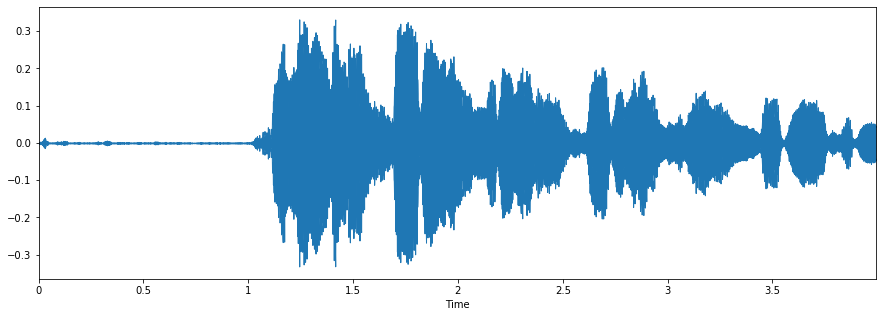

In [16]:
data, sampling_rate = librosa.load('abhiangryoutput10.wav')
data, sampling_rate = librosa.load('abhihappyoutput10.wav')
data, sampling_rate = librosa.load('abhisadoutput10.wav')
data, sampling_rate = librosa.load('kanikahappyoutput10.wav')

%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [54]:
def cnnModel(fileName):
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
    twodim= np.expand_dims(livedf2, axis=2)
    livepreds = loaded_model.predict(twodim, 
                             batch_size=32, 
                             verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print('FROM CNN')
    print(livepredictions)

In [55]:
def knnModel(fileName):
    import pickle
    loaded_model = pickle.load(open('knn_model.sav', 'rb'))
    
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
#     twodim= np.expand_dims(livedf2, axis=1)
    livepreds = loaded_model.predict(livedf2)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print('FROM KNN')
    print(livepredictions)

In [56]:
def rfcModel(fileName):
    import pickle
    loaded_model = pickle.load(open('rfc_model.sav', 'rb'))
    
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
#     twodim= np.expand_dims(livedf2, axis=1)
    livepreds = loaded_model.predict(livedf2)
#     livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print('FROM RFC')
    print(livepredictions)

In [57]:
def svmModel(fileName):
    import pickle
    loaded_model = pickle.load(open('svm_model.sav', 'rb'))
    
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
#     twodim= np.expand_dims(livedf2, axis=1)
    livepreds = loaded_model.predict(livedf2)
#     livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print('FROM SVM')
    print(livepredictions)

In [62]:
cnnModel('abhihappyoutput10.wav')
cnnModel('abhisadoutput10.wav')
cnnModel('abhiangryoutput10.wav')
cnnModel('kanikahappyoutput10.wav')

1/1 [==============================] - 0s 5ms/step
FROM CNN
['male_fearful']


In [63]:
knnModel('abhihappyoutput10.wav')

FROM KNN
['male_happy']


In [64]:
rfcModel('abhihappyoutput10.wav')

FROM rfc
['male_calm']


In [65]:
svmModel('abhihappyoutput10.wav')

FROM SVM
['male_calm']
